In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
import sys
import os
import shutil
import warnings

folder = "content/assignment" #@param {type:"string"}
!ln -Ts $folder /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: CUDA is not available.


### Class NN

In [ ]:
import numpy as np
import torch
import torchvision


def one_hot(y, n_classes=10):
    return np.eye(n_classes)[y]


def load_cifar10(root, flatten=False):
    """
    Usage example:
    > train_data, valid_data, test_data = load_cifar10("/data", flatten=True)
    > train_x, train_y = train_data
    where both train_x and train_y are numpy arrays
    train_x.shape == (40000, 3072) or train_x.shape == (40000, 3, 32, 32)
    train_y.shape == (40000, 10), one-hot format
    :param root: path where the cifar10 dataset will be downloaded, e.g. "/tmp/data/"
    :param flatten: When True, dataset is reshaped to (num_examples, 3072), otherwise shape is (num_examples, 3, 32, 32)
    :return: train, valid and test set in numpy arrays
    """
    transform = torchvision.transforms.ToTensor()

    train_dataset = torchvision.datasets.CIFAR10(root, train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root, train=False, transform=transform, download=True)

    # randomly split train into train/valid
    perm = np.random.RandomState(seed=1).permutation(
        range(len(train_dataset)))  # fix seed to have same split every time.
    x = [train_dataset[i][0] for i in perm]  # train_dataset.data[perm]
    y = [one_hot(train_dataset[i][1]) for i in perm]
    train_x, train_y = x[:40000], y[:40000]
    valid_x, valid_y = x[40000:], y[40000:]
    test_x = [test_dataset[i][0] for i in range(len(test_dataset))]
    test_y = [one_hot(test_dataset[i][1]) for i in range(len(test_dataset))]

    # convert to numpy arrays after stacking
    train_x = torch.stack(train_x).cpu().numpy()
    train_y = np.stack(train_y)
    valid_x = torch.stack(valid_x).cpu().numpy()
    valid_y = np.stack(valid_y)
    test_x = torch.stack(test_x).cpu().numpy()
    test_y = np.stack(test_y)

    if flatten:
        train_x = train_x.reshape(-1, 32 * 32 * 3)
        valid_x = valid_x.reshape(-1, 32 * 32 * 3)
        test_x = test_x.reshape(-1, 32 * 32 * 3)

    # Package everything
    train_data = train_x, train_y
    valid_data = valid_x, valid_y
    test_data = test_x, test_y

    return train_data, valid_data, test_data


class NN(object):
    def __init__(self,
                 hidden_dims=(784, 256),
                 epsilon=1e-6,
                 lr=0.01,
                 batch_size=64,
                 seed=1,
                 activation="tanh",
                 data=None
                 ):

        self.hidden_dims = hidden_dims
        self.n_hidden = len(hidden_dims)
        self.lr = lr
        self.batch_size = batch_size
        self.seed = seed
        self.activation_str = activation
        self.epsilon = epsilon

        self.train_logs = {'train_accuracy': [], 'validation_accuracy': [], 'train_loss': [], 'validation_loss': []}

        if data is None:
            # for testing, do NOT remove or modify
            self.train, self.valid, self.test = (
                (np.random.rand(400, 3072), one_hot(np.random.randint(0, 10, 400))),
                (np.random.rand(400, 3072), one_hot(np.random.randint(0, 10, 400))),
                (np.random.rand(400, 3072), one_hot(np.random.randint(0, 10, 400)))
        )
        else:
            self.train, self.valid, self.test = data


    def initialize_weights(self, dims):        
        if self.seed is not None:
            np.random.seed(self.seed)

        self.weights = {}
        # self.weights is a dictionnary with keys W1, b1, W2, b2, ..., Wm, Bm where m - 1 is the number of hidden layers
        all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
        for layer_n in range(1, self.n_hidden + 2):
            # WRITE CODE HERE

            # self.n_hidden + 2, 2 is due to the input and output layers
            # dims[0] is the dimension of the flattened input, dims[1] is the dimension of the output
            # i.e. the number of classes.

            # biases are initialized to zero
            self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))
            
            # weights are initialized according to the Glorot method
            
            # uniform distribution range: d_l
            d_l = np.sqrt(6/(all_dims[layer_n-1]+all_dims[layer_n]))
            self.weights[f"W{layer_n}"] = np.random.uniform(-d_l,d_l,(all_dims[layer_n-1], all_dims[layer_n]))
            
            # weights are initialized according to the Normal Distribution
            # self.weights[f"W{layer_n}"] = np.random.normal(0,np.sqrt(0.1),(all_dims[layer_n-1], all_dims[layer_n]))


    def relu(self, x, grad=False):
        if grad:
            # WRITE CODE HERE
            return 1.0 * (x > 0)
        # WRITE CODE HERE
        return x * (x > 0)


    def sigmoid(self, x, grad=False):
        if grad:
            # WRITE CODE HERE
            return self.sigmoid(x,grad=False)*(1-self.sigmoid(x,grad=False))
        # WRITE CODE HERE
        return (1+np.exp(-x))**(-1)


    def tanh(self, x, grad=False):
        if grad:
            # WRITE CODE HERE
            return 1-self.tanh(x,grad=False)**2
        # WRITE CODE HERE
        return np.tanh(x)


    def activation(self, x, grad=False):
        if self.activation_str == "relu":
            # WRITE CODE HERE
            return self.relu(x, grad)
        elif self.activation_str == "sigmoid":
            # WRITE CODE HERE
            return self.sigmoid(x, grad)
        elif self.activation_str == "tanh":
            # WRITE CODE HERE
            return self.tanh(x, grad)
        else:
            raise Exception("invalid")

    def softmax(self, x):
        # Remember that softmax(x-C) = softmax(x) when C is a constant.
        # WRITE CODE HERE
        
        # batch_size = x.shape[0]
        # normalizers = np.reshape(np.sum(np.exp(x),axis=1),(batch_size,1))
        # return np.exp(x)/normalizers
        x = x-np.max(x,axis=1,keepdims=True)
        normalizers = np.sum(np.exp(x),axis=len(x.shape)-1, keepdims=True)
        # print(normalizers.shape)
        return np.exp(x)/normalizers

    def forward(self, x):
        cache = {"Z0": x}
        # cache is a dictionnary with keys Z0, A1, Z1, ..., Am, Zm where m - 1 is the number of hidden layers
        # Ai corresponds to the preactivation at layer i, Zi corresponds to the activation at layer i
        # WRITE CODE HERE
        for layer_n in range(1,self.n_hidden+1): # Last layer's activation should be softmax, that's why we differentiate it with the rest
            cache[f"A{layer_n}"] = cache[f"Z{layer_n-1}"]@self.weights[f"W{layer_n}"]+self.weights[f"b{layer_n}"]
            cache[f"Z{layer_n}"] = self.activation(cache[f"A{layer_n}"], grad=False)
        
        cache[f"A{layer_n+1}"] = cache[f"Z{layer_n}"]@self.weights[f"W{layer_n+1}"]+self.weights[f"b{layer_n+1}"]
        cache[f"Z{layer_n+1}"] = self.softmax(cache[f"A{layer_n+1}"])
        return cache
    
    def backward(self, cache, labels):

        output = cache[f"Z{self.n_hidden + 1}"]
        grads = {}
        # grads is a dictionnary with keys dAm, dWm, dbm, dZ(m-1), dA(m-1), ..., dW1, db1
        # WRITE CODE HERE
        
        # Recall that cross entropy and softmax play well together!

        # Gradients in a batch should be averaged along the batch dimension, but
        # not until all gradients are computed! Until then, the gradient for each
        # sample should be kept alive, and when backprop is complete, then all grads
        # can be averaged along the batch dimension to yield a single gradient direction.

        batch_size = output.shape[0]


        # Now this gradient would be batch_size x 10, in the end I'll take the mean.
        # labels are already one-hotted
        grads[f"dA{self.n_hidden+1}"] = -(labels-output)
        
        
        # Gradients for post-activations and pre-activations, weights and biases
        for layer_n in range(self.n_hidden+1,0,-1):
        
            grads[f"dW{layer_n}"] = (cache[f"Z{layer_n-1}"].T)@(grads[f"dA{layer_n}"])/batch_size
            # grads[f"dW{layer_n}"] = (np.expand_dims(grads[f"dA{layer_n}"],-1))@(np.expand_dims(cache[f"Z{layer_n-1}"],1))
            # dims = grads[f"dW{layer_n}"].shape
            # grads[f"dW{layer_n}"] = np.reshape(grads[f"dW{layer_n}"],(dims[0],dims[2],dims[1]))
            
            # grads[f"dW{layer_n}"] = np.reshape(grads[f"dW{layer_n}"],(1,dims[0],dims[1]))

            grads[f"db{layer_n}"] = np.mean(grads[f"dA{layer_n}"],axis=0, keepdims=True)
            
            if (layer_n != 1):
                grads[f"dZ{layer_n-1}"] = ((self.weights[f"W{layer_n}"])@(grads[f"dA{layer_n}"].T)).T
                grads[f"dA{layer_n-1}"] = grads[f"dZ{layer_n-1}"]*self.activation(cache[f"A{layer_n-1}"],grad=True)
                
        # Now we should take the average along the batch dimension
        # for param in grads.keys():
            # grads[param] = np.mean(grads[param], axis=0)


        return grads

    def update(self, grads):
        for layer in range(1, self.n_hidden + 2):
            # WRITE CODE HERE

            # updating weights W
            self.weights[f"W{layer}"] = self.weights[f"W{layer}"] - self.lr*grads[f"dW{layer}"]

            # updating biases b
            self.weights[f"b{layer}"] = self.weights[f"b{layer}"] - self.lr*grads[f"db{layer}"]

    def one_hot(self, y, n_classes=None):
        n_classes = n_classes or self.n_classes
        return np.eye(n_classes)[y]

    def loss(self, prediction, labels):
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        # WRITE CODE HERE
        # labels are one-hot
        sample_losses = [-np.log(prediction[m,np.argmax(labels,axis=1)[m]]) for m in range(len(prediction))]
        return np.mean(sample_losses)

    def compute_loss_and_accuracy(self, X, y):
        one_y = y
        y = np.argmax(y, axis=1)  # Change y to integers
        cache = self.forward(X)
        predictions = np.argmax(cache[f"Z{self.n_hidden + 1}"], axis=1)
        accuracy = np.mean(y == predictions)
        loss = self.loss(cache[f"Z{self.n_hidden + 1}"], one_y)
        return loss, accuracy, predictions

    def train_loop(self, n_epochs):
        X_train, y_train = self.train
        y_onehot = y_train
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims)

        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(n_epochs):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size * (batch + 1), :]
                # WRITE CODE HERE
                cache = self.forward(minibatchX)
                gradients = self.backward(cache,minibatchY)
                self.update(gradients)
                
                if(np.mod(batch,100)==0):
                    train_loss, train_accuracy, _ = self.compute_loss_and_accuracy(minibatchX, minibatchY)
                    print(f"epoch {epoch}, batch id:{batch}, train_loss={train_loss}, train_accuracy={train_accuracy}")


            X_train, y_train = self.train
            train_loss, train_accuracy, _ = self.compute_loss_and_accuracy(X_train, y_train)
            X_valid, y_valid = self.valid
            valid_loss, valid_accuracy, _ = self.compute_loss_and_accuracy(X_valid, y_valid)

            self.train_logs['train_accuracy'].append(train_accuracy)
            self.train_logs['validation_accuracy'].append(valid_accuracy)
            self.train_logs['train_loss'].append(train_loss)
            self.train_logs['validation_loss'].append(valid_loss)

        return self.train_logs

    def evaluate(self):
        X_test, y_test = self.test
        test_loss, test_accuracy, _ = self.compute_loss_and_accuracy(X_test, y_test)
        return test_loss, test_accuracy


## Data utilities (do not modify)

In [ ]:
# from solution import load_cifar10
data = load_cifar10('/tmp/data', flatten=True)  # can use flatten=False to get the image shape.
train_data, valid_data, test_data = data
image, label = train_data[0][0], train_data[1][0]
image.shape

Files already downloaded and verified
Files already downloaded and verified


(3072,)

## Load the `NN` class from your `solution.py`.

In [ ]:
import numpy as np
import torch
import torchvision

In [ ]:
import time
nn = NN(data=data)
start = time.time()
logs = nn.train_loop(1)
print(time.time()-start)
print(nn.evaluate())

import pickle

# with open('logs_normal_lr0007.pickle','wb') as f:
#     pickle.dump(logs,f)

In [ ]:
import pickle

with open('assignment/logs_glorot_tanh_4h.pickle','rb') as f:
    logs = pickle.load(f)

In [ ]:
all_logs = {}

In [ ]:
print(all_logs.keys())
print(all_logs['relu_2h'])
print(all_logs['relu_4h'])
print(all_logs['sigmoid_2h'])
print(all_logs['sigmoid_4h'])
print(all_logs['tanh_2h'])
print(all_logs['tanh_4h'])

dict_keys(['relu_2h', 'relu_4h', 'sigmoid_2h', 'tanh_2h', 'sigmoid_4h', 'tanh_4h'])
{'train_accuracy': [0.385925, 0.419925, 0.442225, 0.456475, 0.4697, 0.4796, 0.48835, 0.49615, 0.50525, 0.513425, 0.521475, 0.529225, 0.53625, 0.542325, 0.54775, 0.554225, 0.558775, 0.564825, 0.570675, 0.574575], 'validation_accuracy': [0.3672, 0.3982, 0.4188, 0.429, 0.4365, 0.4428, 0.4501, 0.4545, 0.4623, 0.4685, 0.4744, 0.4817, 0.4821, 0.489, 0.4887, 0.4912, 0.4946, 0.4975, 0.5016, 0.5005], 'train_loss': [1.7680603579683651, 1.6678484000336502, 1.6037593796983873, 1.5593552722886521, 1.5224483678975258, 1.4910502370393897, 1.4646393900085353, 1.4395275564080598, 1.4140856881180563, 1.3926059799953796, 1.3691869762212896, 1.347353631033278, 1.3285133073128186, 1.3083279250970525, 1.293010078726069, 1.275500391315157, 1.2598264424717975, 1.2430411714288296, 1.2264587185657048, 1.214995224551546], 'validation_loss': [1.7874823308258136, 1.6959772290217843, 1.6420255839987563, 1.6071756683037117, 1.5789802

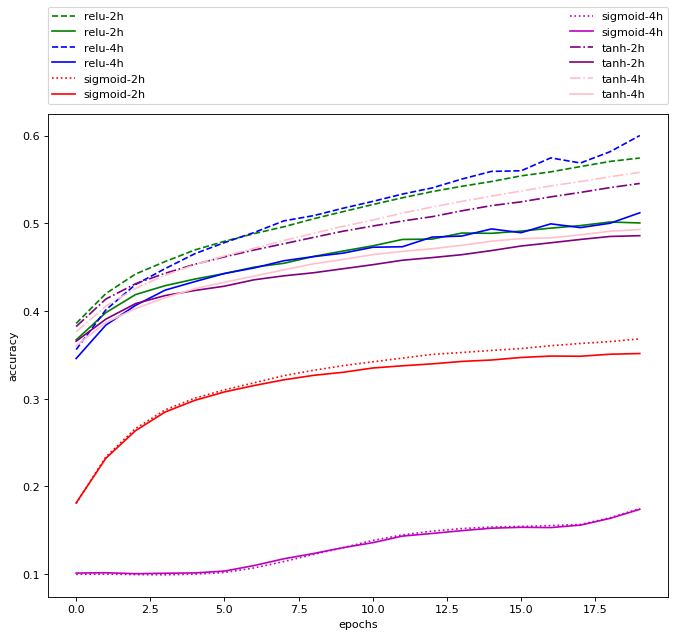

In [ ]:
# Plotting train vs. validation "accuracy" for all
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

epochs = 20
plt.plot(np.arange(epochs), all_logs['relu_2h']['train_accuracy'], label='relu-2h', linestyle='dashed', color='green')
plt.plot(np.arange(epochs), all_logs['relu_2h']['validation_accuracy'], label='relu-2h', color='green')

plt.plot(np.arange(epochs), all_logs['relu_4h']['train_accuracy'], linestyle='dashed', color='blue', label='relu-4h')
plt.plot(np.arange(epochs), all_logs['relu_4h']['validation_accuracy'], color='blue', label='relu-4h')

plt.plot(np.arange(epochs), all_logs['sigmoid_2h']['train_accuracy'], linestyle=':', color='red', label='sigmoid-2h')
plt.plot(np.arange(epochs), all_logs['sigmoid_2h']['validation_accuracy'], color='red', label='sigmoid-2h')

plt.plot(np.arange(epochs), all_logs['sigmoid_4h']['train_accuracy'], linestyle=':', color='m', label='sigmoid-4h')
plt.plot(np.arange(epochs), all_logs['sigmoid_4h']['validation_accuracy'], color='m', label='sigmoid-4h')

plt.plot(np.arange(epochs), all_logs['tanh_2h']['train_accuracy'], linestyle='-.', color='purple', label='tanh-2h')
plt.plot(np.arange(epochs), all_logs['tanh_2h']['validation_accuracy'], color='purple', label='tanh-2h')

plt.plot(np.arange(epochs), all_logs['tanh_4h']['train_accuracy'], linestyle='-.', color='pink', label='tanh-4h')
plt.plot(np.arange(epochs), all_logs['tanh_4h']['validation_accuracy'], color='pink', label='tanh-4h')
# error = np.array(logs['train_accuracy'])+0.005
# error_1 = np.array(logs['train_accuracy'])-0.005
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error, alpha = 0.5)
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error_1, alpha = 0.5)
plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

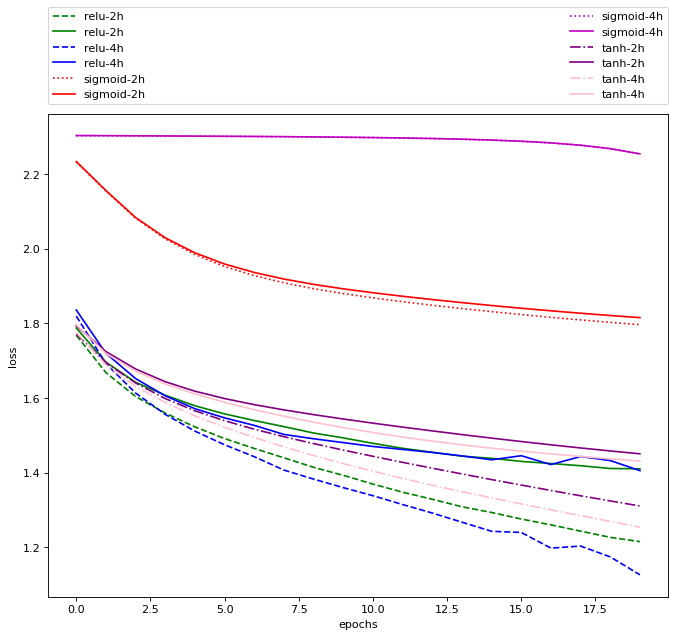

In [ ]:
# Plotting train vs. validation "loss" for all
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), all_logs['relu_2h']['train_loss'], label='relu-2h', linestyle='dashed', color='green')
plt.plot(np.arange(epochs), all_logs['relu_2h']['validation_loss'], label='relu-2h', color='green')

plt.plot(np.arange(epochs), all_logs['relu_4h']['train_loss'], linestyle='dashed', color='blue', label='relu-4h')
plt.plot(np.arange(epochs), all_logs['relu_4h']['validation_loss'], color='blue', label='relu-4h')

plt.plot(np.arange(epochs), all_logs['sigmoid_2h']['train_loss'], linestyle=':', color='red', label='sigmoid-2h')
plt.plot(np.arange(epochs), all_logs['sigmoid_2h']['validation_loss'], color='red', label='sigmoid-2h')

plt.plot(np.arange(epochs), all_logs['sigmoid_4h']['train_loss'], linestyle=':', color='m', label='sigmoid-4h')
plt.plot(np.arange(epochs), all_logs['sigmoid_4h']['validation_loss'], color='m', label='sigmoid-4h')

plt.plot(np.arange(epochs), all_logs['tanh_2h']['train_loss'], linestyle='-.', color='purple', label='tanh-2h')
plt.plot(np.arange(epochs), all_logs['tanh_2h']['validation_loss'], color='purple', label='tanh-2h')

plt.plot(np.arange(epochs), all_logs['tanh_4h']['train_loss'], linestyle='-.', color='pink', label='tanh-4h')
plt.plot(np.arange(epochs), all_logs['tanh_4h']['validation_loss'], color='pink', label='tanh-4h')
# error = np.array(logs['train_accuracy'])+0.005
# error_1 = np.array(logs['train_accuracy'])-0.005
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error, alpha = 0.5)
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error_1, alpha = 0.5)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [ ]:
all_logs_init = {}

In [ ]:
with open('assignment/logs_normal_lr01.pickle','rb') as f:
    logs = pickle.load(f)

In [ ]:
all_logs_init['normal'] = logs
# print(all_logs_init['normal'])
# print(all_logs_init['glorot'])

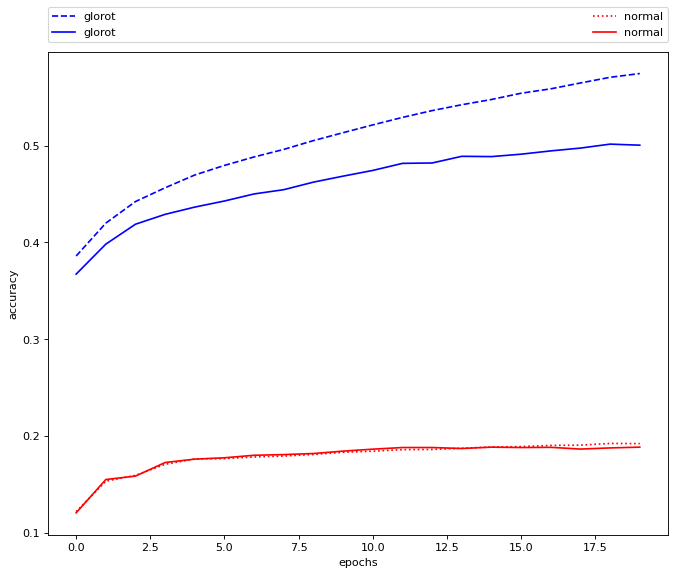

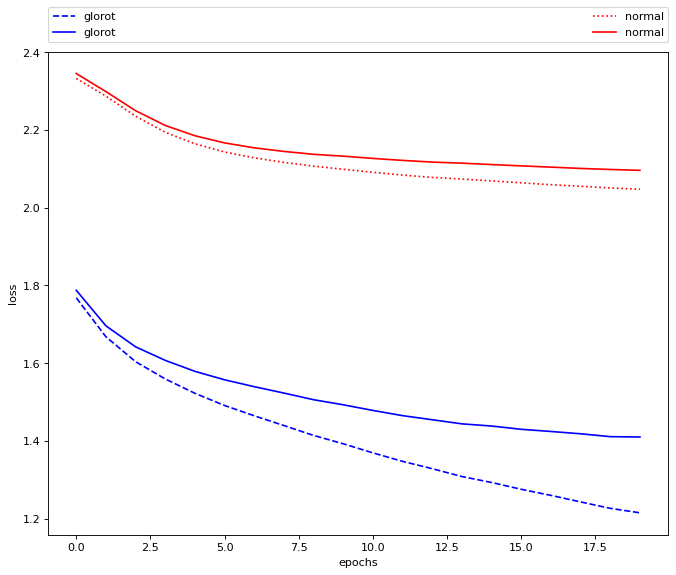

In [ ]:
# Plotting train vs. validation "accuracy" for glorot and normal init
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), all_logs_init['glorot']['train_accuracy'], label='glorot', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), all_logs_init['glorot']['validation_accuracy'], label='glorot', color='blue')

plt.plot(np.arange(epochs), all_logs_init['normal']['train_accuracy'], linestyle=':', color='red', label='normal')
plt.plot(np.arange(epochs), all_logs_init['normal']['validation_accuracy'], color='red', label='normal')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), all_logs_init['glorot']['train_loss'], label='glorot', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), all_logs_init['glorot']['validation_loss'], label='glorot', color='blue')

plt.plot(np.arange(epochs), all_logs_init['normal']['train_loss'], linestyle=':', color='red', label='normal')
plt.plot(np.arange(epochs), all_logs_init['normal']['validation_loss'], color='red', label='normal')
# error = np.array(logs['train_accuracy'])+0.005
# error_1 = np.array(logs['train_accuracy'])-0.005
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error, alpha = 0.5)
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error_1, alpha = 0.5)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [ ]:
with open('assignment/all_logs_hp_search.pickle','wb') as f:
    pickle.dump(all_logs,f)

In [ ]:
import time
nn = NN(data=data)
start = time.time()
logs = nn.train_loop(20)
print(time.time()-start)
print(nn.evaluate())

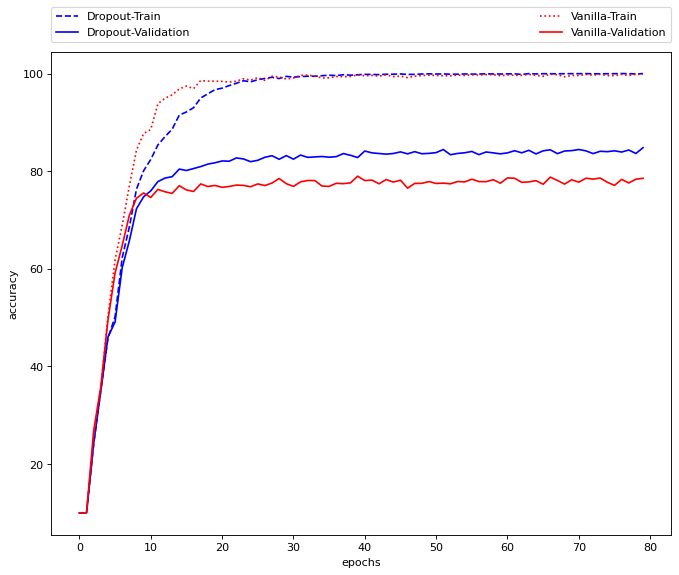

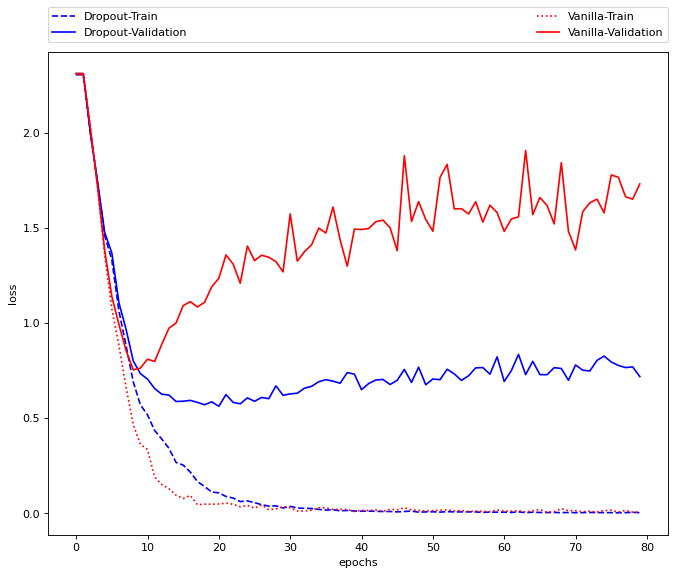

In [ ]:
# Plotting train vs. validation "accuracy" for glorot and normal init
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle
import numpy as np
epochs = 80
with open('logs_dropout_80_epoch.pickle','rb') as f:
    logs_do = pickle.load(f)

with open('logs_vanilla_80_epoch.pickle','rb') as f:
    logs_v = pickle.load(f)

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), logs_do['train_accuracy'], label='Dropout-Train', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), logs_do['validation_accuracy'], label='Dropout-Validation', color='blue')

plt.plot(np.arange(epochs), logs_v['train_accuracy'], linestyle=':', color='red', label='Vanilla-Train')
plt.plot(np.arange(epochs), logs_v['validation_accuracy'], color='red', label='Vanilla-Validation')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), logs_do['train_loss'], label='Dropout-Train', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), logs_do['validation_loss'], label='Dropout-Validation', color='blue')

plt.plot(np.arange(epochs), logs_v['train_loss'], linestyle=':', color='red', label='Vanilla-Train')
plt.plot(np.arange(epochs), logs_v['validation_loss'], color='red', label='Vanilla-Validation')
# error = np.array(logs['train_accuracy'])+0.005
# error_1 = np.array(logs['train_accuracy'])-0.005
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error, alpha = 0.5)
# plt.fill_between(np.arange(epochs), logs['train_accuracy'], error_1, alpha = 0.5)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()